# Initial imports and definitions

In [1]:
import zipfile
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
import geopy.distance
from matplotlib import cm
from io import StringIO
import json

In [2]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering
import numpy as np

def plot_dendrogram(model, plot=False, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    order = dendrogram(linkage_matrix, no_plot = not plot, get_leaves=True, **kwargs)['leaves']
    return linkage_matrix, order


def elbow(data):
    elbowdata = np.array(data)
    if elbowdata.shape[1] != 2:
        elbowdata = elbowdata.T
    elbowdata -= elbowdata[0]
    rotation = np.linalg.inv(np.vstack([elbowdata[-1], [-elbowdata[-1,1], elbowdata[-1,0]]]).T)
    idx = np.argmin((elbowdata @rotation.T)[:,1])
    return idx    


def autocluster(data, return_order=False, return_linkage=False, plot=False, **kwargs):
    ag = AgglomerativeClustering(distance_threshold=0,n_clusters=None,**kwargs)
    ag.fit(data)
    linkage_matrix, order = plot_dendrogram(ag)
    idx = len(linkage_matrix) - elbow(list(enumerate(linkage_matrix[:,2])))
    if plot:
        plt.plot(linkage_matrix[:,2][::-1])
        plt.show()
    print("number of clusters: ", idx)
    ag2 = AgglomerativeClustering(n_clusters=idx, **kwargs)
    ag2.fit(data)
    ret = [ag2]
    if return_order:
        ret.append(order)
    if return_linkage:
        ret.append(linkage_matrix)
    return tuple(ret) if len(ret) > 1 else ret[0]

In [3]:
def plot_abq(data, first=True, **kwargs):
    if first:
        print('loading image')
        img = Image.open('abqmap2.png')
        plt.figure(figsize=(10,10))
        plt.imshow(img)
    for row in data:
        if 'latitude' in row:
            plot(row['latitude'], row['longitude'], **kwargs)
        else:
            plot(*row, **kwargs)
def plot(lat,lon,c, **kwargs):
    A = np.array([[ 3.30048468e+00, -1.76873312e+03],
       [ 1.44506111e+03, -7.69612341e+00],
       [ 1.54147586e+05,  6.14923771e+04]]).T
    pltx = A[1]@[lat,lon,1]
    plty = A[0]@[lat,lon,1]
    plt.scatter([plty], [pltx], color=c, **kwargs)

# right, need to convert lat/lon to euclidean
origin_x = -106.544256
origin_y = 35.034674
foot_x = 1
d = geopy.distance.geodesic( (origin_y, origin_x), (origin_y, origin_x + foot_x)).feet
while abs(d-1) > 1e-5:
    if d > 1:
        foot_x *= 0.9
    else:
        foot_x *= 1.05
        
    d = geopy.distance.geodesic( (origin_y, origin_x), (origin_y, origin_x + foot_x)).feet
foot_y = 1
d = geopy.distance.geodesic( (origin_y, origin_x), (origin_y+foot_y, origin_x)).feet
while abs(d-1) > 1e-5:
    if d > 1:
        foot_y *= 0.9
    else:
        foot_y *= 1.05
    d = geopy.distance.geodesic( (origin_y, origin_x), (origin_y+foot_y, origin_x)).feet
    

def ll2euclid(ptx, pty):
    pt = np.array([ptx, pty])
    pt -= [origin_y, origin_x]
    pt /= [foot_y, foot_x]
    return pt

In [4]:
def trip2array(trip, n):
    locations = np.zeros((n,2))
    msg_times = np.array([str2time(t) for t in trip['msg_time']])
    for i,t in zip(range(n), np.linspace(min(msg_times),max(msg_times),n, endpoint=False)):
        x = np.argmax(msg_times > t)
        locations[i] = ((trip['latitude'].iloc[x] + trip['latitude'].iloc[x-1])/2, (trip['longitude'].iloc[x] + trip['longitude'].iloc[x-1])/2)
    return locations

def str2time(s):
    hour,minute,second = list(map(int,s.split(':')))
    return second + 60*minute + 60*60*hour

with open('stoplocations.json') as file:
    stoplocations = json.load(file)
    
with open('stopnames.json') as file:
    stopnames = json.load(file)

# The analysis

In [5]:
full_days = '10_11 10_10 10_8 10_9 9_28 9_23 9_21 9_22 9_12 10_7 9_19 9_16 9_17 9_18'.split()
all_arts = []
art_trips = set()
for day in tqdm(full_days):
    with zipfile.ZipFile('../busdata/bus.zip') as file:
        with file.open(f'bus_data_2022_{day}.csv') as myfile:
            data = myfile.read()
    

    df = pd.read_csv(StringIO(data.decode()))
    arts = df[df.route_short_name=='66']
    art_tripset = set(arts.trip_id)
    art_trips = art_trips.union(art_tripset)
    for id in art_tripset:
        all_arts.append(arts[arts.trip_id == id])

100%|██████████████████████████| 14/14 [00:39<00:00,  2.84s/it]


In [6]:
len(all_arts)

1499

In [7]:
trip_arrays = []
for art in tqdm(all_arts):
        trip = art.sort_values('msg_time', key=lambda x: [str2time(y) for y in x])
        trip_arrays.append(trip2array(trip,100))
trip_arrays = np.array(trip_arrays)

100%|█████████████████████| 1499/1499 [00:08<00:00, 168.39it/s]


C:\Users\patri\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


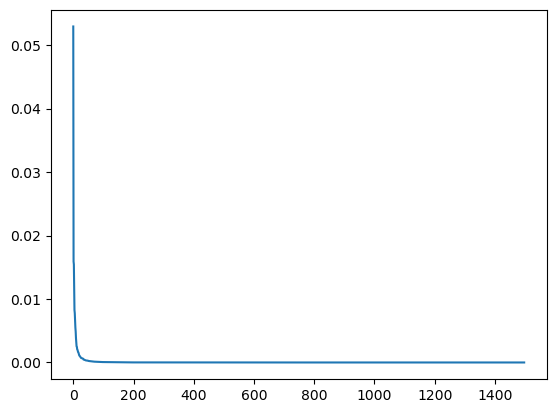

number of clusters:  27


C:\Users\patri\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


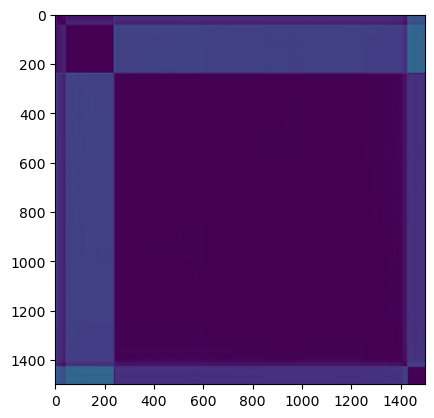

In [8]:
from scipy.stats import kendalltau
dist_mat = np.zeros((len(trip_arrays),len(trip_arrays)))
for i,t1 in enumerate(trip_arrays):
    for j,t2 in enumerate(trip_arrays[i+1:]):
        dist_mat[i,i+j+1] =  abs(t1[:,0].max() - t2[:,0].max())
#         dist_mat[i,i+j+1] = kendalltau(t1[:,0],t2[:,0])[1] + kendalltau(t1[:,1],t2[:,1])[1]
#         dist_mat[i,i+j+1] = (1-kendalltau(t1[:,0],t2[:,0])[0]) * (1-kendalltau(t1[:,1],t2[:,1])[0])
#         x = ((t - np.mean(t,axis=0))*(t2 - np.mean(t2,axis=0))).sum(0)
#         y,z = np.linalg.norm((t - np.mean(t,axis=0)), axis=0),np.linalg.norm((t2 - np.mean(t2,axis=0)), axis=0)
#         dist_mat[i,i+j+1] = 1-x[0]*x[1]/(y[0]*y[1]*z[0]*z[1])
dist_mat += dist_mat.T
# .square( trip_arrays[:,None] - trip_arrays[None]).sum(-1).max(-1)**0.5
ag, lmat = autocluster(dist_mat, return_order=True, plot=True, affinity="precomputed", linkage='average')
order = lmat#['leaves']
plt.imshow(dist_mat[order][:,order])
plt.show()

In [9]:
correct_cluster = np.argmax([sum(ag.labels_==i) for i in range(ag.n_clusters)])
print("correct cluster is ", correct_cluster)
valid_arts = [ a for i,a in enumerate(all_arts) if ag.labels_[i]==correct_cluster]
print(len(valid_arts))

correct cluster is  11
1152


In [10]:
with open('stoplookup.json') as file:
    tripstops = json.load(file)
tripstops

{'704230369': [1, 2],
 '2013': [1],
 '2015': [1],
 '2017': [1],
 '2019': [1],
 '2021': [1],
 '2023': [1],
 '2025': [1],
 '2027': [1],
 '2029': [1],
 '2031': [1],
 '2033': [1],
 '704230838': [1],
 '2037': [1],
 '2039': [1],
 '2043': [1],
 '2045': [1],
 '2047': [1],
 '704230443': [1],
 '2051': [1],
 '2053': [1],
 '2055': [1],
 '2057': [1],
 '2059': [1],
 '2061': [1],
 '2063': [1],
 '2065': [1],
 '2067': [1],
 '2069': [1],
 '2071': [1],
 '2073': [1],
 '2075': [1],
 '2077': [1],
 '2079': [1],
 '2083': [1],
 '2085': [1],
 '704230700': [1],
 '2089': [1],
 '704230761': [1],
 '2093': [1],
 '2095': [1],
 '2097': [1],
 '2099': [1],
 '2101': [1],
 '2103': [1],
 '2105': [1, 66],
 '4553': [1, 66],
 '704230701': [1, 66],
 '1925': [1, 66],
 '1927': [1],
 '1929': [1],
 '1931': [1],
 '1933': [1],
 '1935': [1],
 '1937': [1],
 '704230759': [1],
 '704230760': [1],
 '1943': [1],
 '1945': [1],
 '704231134': [1],
 '1949': [1],
 '1953': [1],
 '1955': [1],
 '1957': [1],
 '1959': [1],
 '1961': [1],
 '704230702'

In [15]:
# filter by how close they are to real stops
real_artstop_locations = [ stoplocations[s] for s,v in tqdm(tripstops.items()) if 66 in v]
real_artstop_locations

100%|██████████████████| 2372/2372 [00:00<00:00, 912993.40it/s]


[{'lat': 35.06713, 'lng': -106.503359},
 {'lat': 35.068639000000005, 'lng': -106.503054},
 {'lat': 35.065946000000004, 'lng': -106.49868700000002},
 {'lat': 35.066145, 'lng': -106.50229099999999},
 {'lat': 35.080263, 'lng': -106.607281},
 {'lat': 35.080615, 'lng': -106.609775},
 {'lat': 35.080665, 'lng': -106.611778},
 {'lat': 35.080059000000006, 'lng': -106.607477},
 {'lat': 35.094675, 'lng': -106.67078000000001},
 {'lat': 35.094808, 'lng': -106.67047600000001},
 {'lat': 35.083684000000005, 'lng': -106.65349199999999},
 {'lat': 35.069155, 'lng': -106.505551},
 {'lat': 35.069340000000004, 'lng': -106.50733899999999},
 {'lat': 35.069725, 'lng': -106.510873},
 {'lat': 35.069974, 'lng': -106.513148},
 {'lat': 35.070278, 'lng': -106.515929},
 {'lat': 35.070572999999996, 'lng': -106.518662},
 {'lat': 35.070938, 'lng': -106.52188899999999},
 {'lat': 35.071203999999994, 'lng': -106.524437},
 {'lat': 35.07159, 'lng': -106.52793100000001},
 {'lat': 35.071946000000004, 'lng': -106.531248},
 {'la

In [12]:
## I could also just identify the spots where it stops
art_stops = []
speed_limit = 5
stupid_trips = []
for idx, art in enumerate(tqdm(valid_arts)):
#     art = df[df.trip_id == artid]
    art = art.iloc[np.argsort(art.msg_time)]
    prev_speed = 100
    lat = 0
    lng = 0
    stop_start = -1
    duration = 0
    for _,row in art.iterrows():
        eastbound = art.iloc[0].longitude < art.iloc[-1].longitude
        if row.speed_mph < speed_limit and 100 < min([geopy.distance.geodesic((row.latitude,row.longitude), (b['lat'], b['lng'])).feet for b in real_artstop_locations]):
#             if prev_speed < speed_limit:
                duration_delta = str2time(row.msg_time) - stop_start
                duration += duration_delta
                lat += duration_delta * row.latitude
                lng += duration_delta * row.longitude
#                 stop_start = str2time(row.msg_time)
#                 continue
#             elif duration > 0:
#                 stop_start = str2time(row.msg_time)
#                 stop_location = (lat / duration, lng/duration)
                
# #                 prev_speed = 0
                
#                 duration = 0
#                 lat = 0
#                 lng = 0
        else:
            if duration > 0:
                art_stops.append(((lat / duration, lng/duration), duration, idx, eastbound))
                if duration > 40000:
                    stupid_trips.append((arts, art_stops[-1]))
                lat = 0
                lng = 0
                duration = 0
                
                
        stop_start = str2time(row.msg_time)
        prev_speed = row.speed_mph

100%|██████████████████████| 1152/1152 [27:34<00:00,  1.44s/it]


In [13]:
# art_stops = [ dict(lat=a[0][0], lng=a[0][1], duration=a[1], dist_to_station=min(geopy.distance.geodesic())]
art_stop_info = []
for a in tqdm(art_stops):
    lat = a[0][0]
    lng = a[0][1]
    duration = a[1]
    
    dist_to_station = min([geopy.distance.geodesic((lat,lng), (b['lat'], b['lng'])).feet for b in real_artstop_locations])
    art_stop_info.append(dict(lat=lat, lng=lng, duration=duration, dist_to_station=dist_to_station, id=a[2], eastbound=a[3]))

far_stops = [ a for a in art_stop_info if a['dist_to_station'] > 100 ]
len(far_stops)

100%|███████████████████| 48001/48001 [05:13<00:00, 153.07it/s]


47858

In [14]:
far_stops_euclid = [ ll2euclid(d['lat'], d['lng'])  for d in far_stops]
ag = autocluster(far_stops_euclid)

KeyboardInterrupt: 

In [ ]:
# ag = AgglomerativeClustering(n_clusters=None, distance_threshold=300, linkage='complete')
# ag.fit([ ll2euclid(d['lat'], d['lng']) for d in far_stops])

In [ ]:
# now find cluster centers and count total delay
cluster_groups = [[] for _ in range(ag.n_clusters_)]
cluster_groups_eb = [[] for _ in range(ag.n_clusters_)]
cluster_groups_wb = [[] for _ in range(ag.n_clusters_)]
for i,stop in enumerate(tqdm(far_stops)):
    cluster_groups[ag.labels_[i]].append(stop)
    if stop['eastbound']:
        cluster_groups_eb[ag.labels_[i]].append(stop)
    else:
        cluster_groups_wb[ag.labels_[i]].append(stop)

max_radius = 300
clusters = []
for i,gp in enumerate(tqdm(cluster_groups)):
    lat = np.mean([g['lat'] for g in gp])
    lng = np.mean([g['lng'] for g in gp])
    rads = [ np.linalg.norm(ll2euclid(lat, lng) - ll2euclid(g['lat'], g['lng'])) for g in gp]
    lat = np.mean([g['lat'] for g,r in zip(gp, rads) if r < max_radius])
    lng = np.mean([g['lng'] for g,r in zip(gp, rads) if r < max_radius])
    duration = sum([g['duration'] for g,r in zip(gp, rads) if r < max_radius])
    durations = [g['duration'] for g,r in zip(gp, rads) if r < max_radius]
    
#     radius = max([r for g,r in zip(gp, rads) if r < max_radius])
    counts = len(set([g['id'] for g,r in zip(gp, rads) if r < max_radius]))
    clusters.append( dict(lat=lat, lng=lng, duration=duration, counts=counts, durations=durations))#, radius=radius))
    

max_radius = 300
clusters_eb = []
for i,gp in enumerate(tqdm(cluster_groups_eb)):
    lat = np.mean([g['lat'] for g in gp])
    lng = np.mean([g['lng'] for g in gp])
    rads = [ np.linalg.norm(ll2euclid(lat, lng) - ll2euclid(g['lat'], g['lng'])) for g in gp]
    lat = np.mean([g['lat'] for g,r in zip(gp, rads) if r < max_radius])
    lng = np.mean([g['lng'] for g,r in zip(gp, rads) if r < max_radius])
    duration = sum([g['duration'] for g,r in zip(gp, rads) if r < max_radius])
    durations = [g['duration'] for g,r in zip(gp, rads) if r < max_radius]
    
#     radius = max([r for g,r in zip(gp, rads) if r < max_radius])
    counts = len(set([g['id'] for g,r in zip(gp, rads) if r < max_radius]))
    clusters_eb.append( dict(lat=lat, lng=lng, duration=duration, counts=counts, durations=durations))#, radius=radius))
    

max_radius = 300
clusters_wb = []
for i,gp in enumerate(tqdm(cluster_groups_wb)):
    lat = np.mean([g['lat'] for g in gp])
    lng = np.mean([g['lng'] for g in gp])
    rads = [ np.linalg.norm(ll2euclid(lat, lng) - ll2euclid(g['lat'], g['lng'])) for g in gp]
    lat = np.mean([g['lat'] for g,r in zip(gp, rads) if r < max_radius])
    lng = np.mean([g['lng'] for g,r in zip(gp, rads) if r < max_radius])
    duration = sum([g['duration'] for g,r in zip(gp, rads) if r < max_radius])
    durations = [g['duration'] for g,r in zip(gp, rads) if r < max_radius]
    
#     radius = max([r for g,r in zip(gp, rads) if r < max_radius])
    counts = len(set([g['id'] for g,r in zip(gp, rads) if r < max_radius]))
    clusters_wb.append( dict(lat=lat, lng=lng, duration=duration, counts=counts, durations=durations))#, radius=radius))

In [ ]:
for i,cluster in enumerate(tqdm(clusters)):
    plot_abq([(cluster['lat'], cluster['lng'])], first=i==0, c=cm.plasma((ag.labels_[i] **2 % 17)/17), alpha=0.7, s=10*np.sqrt(cluster['duration']))


In [ ]:
for i,cluster in enumerate(sorted(clusters, key=lambda x: -x['duration'])):
    print('Cluster ', i+1)
    print('\tLat/lon: ', round(cluster['lat'],8), ', ', round(cluster['lng'],8))
    print('\tTotal delay: ', cluster['duration']/60, 'min')
    print('\tNumber of stops: ', cluster['counts'])
    print('\tAverage delay: ', cluster['duration'] / (60 * cluster['counts']), 'min')
    print(f'\t\t25%ile: {round(np.quantile(cluster["durations"], 0.25)/60, 3)}')
    print(f'\t\t50%ile: {round(np.quantile(cluster["durations"], 0.5)/60, 3)}')
    print(f'\t\t75%ile: {round(np.quantile(cluster["durations"], 0.75)/60, 3)}')
    print()


In [ ]:
for i,cluster in enumerate(sorted(clusters, key=lambda x: -np.median(x['durations'])*len(x['durations']))):
    print('Cluster ', i+1)
    print('\tLat/lon: ', round(cluster['lat'],8), ', ', round(cluster['lng'],8))
    print('\tTotal delay: ', np.median(cluster['durations'])*len(cluster['durations'])/60, 'min')
    print('\tNumber of stops: ', cluster['counts'])
    print('\tAverage delay: ', cluster['duration'] / (60 * cluster['counts']), 'min')
    print(f'\t\t25%ile: {round(np.quantile(cluster["durations"], 0.25)/60, 3)}')
    print(f'\t\t50%ile: {round(np.quantile(cluster["durations"], 0.5)/60, 3)}')
    print(f'\t\t75%ile: {round(np.quantile(cluster["durations"], 0.75)/60, 3)}')
    print()


In [ ]:
for i,cluster in enumerate(sorted(clusters, key=lambda x: -sum([d for d in x['durations'] if d < 10000]))):
    print('Cluster ', i+1)
    print('\tLat/lon: ', round(cluster['lat'],8), ', ', round(cluster['lng'],8))
    print('\tTotal delay: ',sum([d for d in cluster['durations'] if d < 10000])/60, 'min')
    print('\tNumber of stops: ', cluster['counts'])
    print('\tAverage delay: ', cluster['duration'] / (60 * cluster['counts']), 'min')
    print(f'\t\t25%ile: {round(np.quantile(cluster["durations"], 0.25)/60, 3)}')
    print(f'\t\t50%ile: {round(np.quantile(cluster["durations"], 0.5)/60, 3)}')
    print(f'\t\t75%ile: {round(np.quantile(cluster["durations"], 0.75)/60, 3)}')
#     print('\tRadius: ', max())
    print()


In [ ]:
print('Eastbound')
for i,cluster in enumerate(sorted(clusters_eb, key=lambda x: -sum([d for d in x['durations'] if d < 10000]))):
    print('Cluster ', i+1)
    print('\tLat/lon: ', round(cluster['lat'],8), ', ', round(cluster['lng'],8))
    print('\tTotal delay: ',sum([d for d in cluster['durations'] if d < 10000])/60, 'min')
    print('\tNumber of stops: ', cluster['counts'])
    print('\tAverage delay: ', cluster['duration'] / (60 * cluster['counts']), 'min')
    print(f'\t\t25%ile: {round(np.quantile(cluster["durations"], 0.25)/60, 3)}')
    print(f'\t\t50%ile: {round(np.quantile(cluster["durations"], 0.5)/60, 3)}')
    print(f'\t\t75%ile: {round(np.quantile(cluster["durations"], 0.75)/60, 3)}')
#     print('\tRadius: ', max())
    print()


In [ ]:
print('Westbound')
for i,cluster in enumerate(sorted(clusters_wb, key=lambda x: -sum([d for d in x['durations'] if d < 10000]))):
    print('Cluster ', i+1)
    print('\tLat/lon: ', round(cluster['lat'],8), ', ', round(cluster['lng'],8))
    print('\tTotal delay: ',sum([d for d in cluster['durations'] if d < 10000])/60, 'min')
    print('\tNumber of stops: ', cluster['counts'])
    print('\tAverage delay: ', cluster['duration'] / (60 * cluster['counts']), 'min')
    print(f'\t\t25%ile: {round(np.quantile(cluster["durations"], 0.25)/60, 3)}')
    print(f'\t\t50%ile: {round(np.quantile(cluster["durations"], 0.5)/60, 3)}')
    print(f'\t\t75%ile: {round(np.quantile(cluster["durations"], 0.75)/60, 3)}')
#     print('\tRadius: ', max())
    print()


In [ ]:
for i,cluster in enumerate(sorted(clusters, key=lambda x: -x['duration'])[:25]):
    plot_abq([(cluster['lat'], cluster['lng'])], first=i==0, c=cm.plasma((ag.labels_[i] **2 % 17)/17), alpha=0.7, s=10*np.sqrt(sum([d for d in cluster['durations'] if d < 10000])))


In [ ]:
(sum([ sum([d for d in cluster['durations'] if d < 10000])/60  for i,cluster in enumerate(clusters) if i not in [0,9]]) ) / (940)

In [ ]:
(sum([ sum([d for d in cluster['durations'] if d < 10000])/60  for i,cluster in enumerate(sorted(clusters, key=lambda x: -sum([d for d in x['durations'] if d < 10000]))) if i not in [0,9]]) ) / (940)

In [ ]:
(sum([d for x in clusters for d in x['durations'] if d < 10000])) / (60*940)

In [ ]:
(sum([ c['duration'] for c in sorted(clusters, key=lambda x: -x['duration'] )[:25] ])) / (60*940)

In [ ]:
(sum([ (c['duration'])  for c in clusters if c['duration'] < 4000*60 and c['counts'] != 407]) ) / (60*940)

In [ ]:
(sum([ c['duration'] for c in sorted(clusters, key=lambda x: -x['duration'] )[:25] if c['duration'] < 4000*60 and c['counts'] != 407])) / (60*940)

In [ ]:
(sum([ c['duration'] for c in sorted(clusters, key=lambda x: -x['duration'] )[:25] if c['duration'] < 2000*60 and c['counts'] != 407])) / (60*940)

In [ ]:
jt = sorted(clusters, key=lambda x: -x['duration'] )[1]
jt['duration']

In [ ]:
for i,cluster in enumerate(sorted(clusters, key=lambda x: -x['counts'])):
    print('Cluster ', i+1)
    print('\tLat/lon: ', round(cluster['lat'],8), ', ', round(cluster['lng'],8))
    print('\tTotal delay: ',sum([d for d in cluster['durations'] if d < 10000])/60, 'min')
    print('\tNumber of stops: ', cluster['counts'])
    print('\tAverage delay: ', cluster['duration'] / (60 * cluster['counts']), 'min')
    print(f'\t\t25%ile: {round(np.quantile(cluster["durations"], 0.25)/60, 3)}')
    print(f'\t\t50%ile: {round(np.quantile(cluster["durations"], 0.5)/60, 3)}')
    print(f'\t\t75%ile: {round(np.quantile(cluster["durations"], 0.75)/60, 3)}')
#     print('\tRadius: ', max())
    print()


In [ ]:
for i,cluster in enumerate(sorted(clusters, key=lambda x: -sum([d for d in x['durations'] if d < 10000])/x['counts'])):
    print('Cluster ', i+1)
    print('\tLat/lon: ', round(cluster['lat'],8), ', ', round(cluster['lng'],8))
    print('\tTotal delay: ',sum([d for d in cluster['durations'] if d < 10000])/60, 'min')
    print('\tNumber of stops: ', cluster['counts'])
    print('\tAverage delay: ', sum([d for d in cluster['durations'] if d < 10000]) / (60 * cluster['counts']), 'min')
    print(f'\t\t25%ile: {round(np.quantile(cluster["durations"], 0.25)/60, 3)}')
    print(f'\t\t50%ile: {round(np.quantile(cluster["durations"], 0.5)/60, 3)}')
    print(f'\t\t75%ile: {round(np.quantile(cluster["durations"], 0.75)/60, 3)}')
#     print('\tRadius: ', max())
    print()


In [ ]:
print(np.median(jt['durations']))
print(np.mean(jt['durations']))

In [ ]:
plt.hist(jt['durations'])

# Auxiliary stuff

In [ ]:
trip_durations = []
for art in valid_arts:
    msg_times = [str2time(t) for t in art.msg_time]
    trip_durations.append( max(msg_times) - min(msg_times))
plt.hist(trip_durations)

In [ ]:
np.median(trip_durations)

In [ ]:
[s for s in stopnames.values() if 'ART' in s]

In [ ]:
set(art[art.next_stop_name=='ART - Nob Hill East Station'].next_stop_sched_time)

In [ ]:
set(art[art.next_stop_name=='ART - UNM / CNM Station'].next_stop_sched_time)

In [ ]:
(str2time('17:13:17') - str2time('17:06:29'))/60

In [ ]:
df